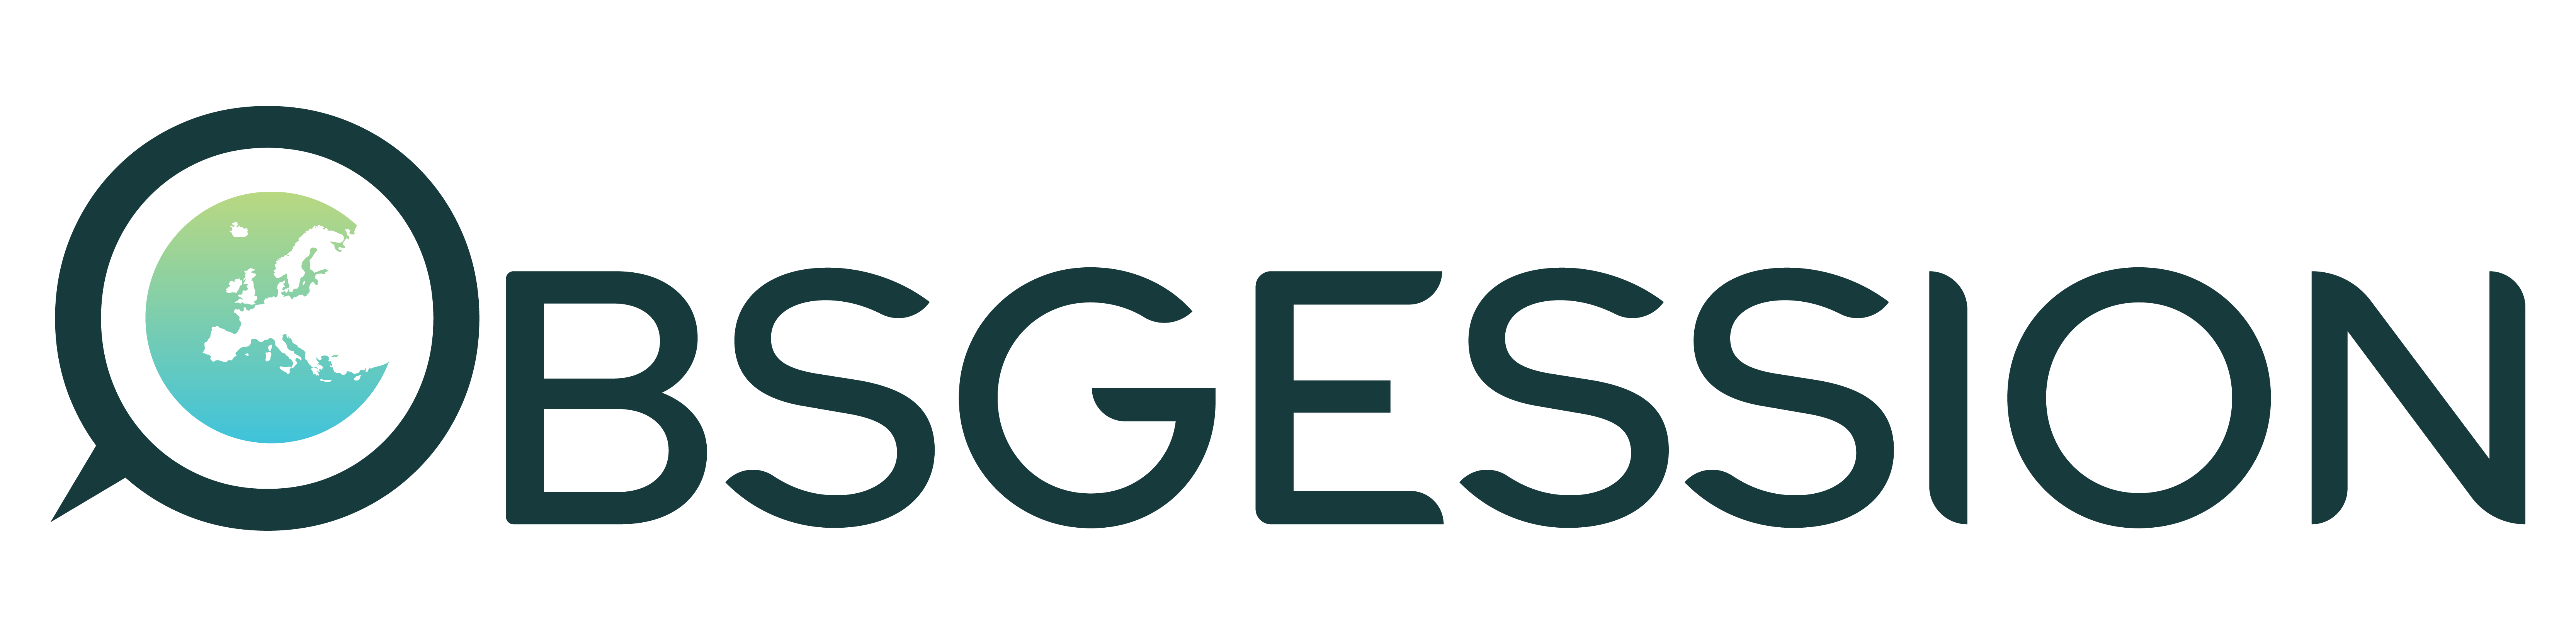

# OBSGESSION internal workshop on EBV-enabling data & data infrastructure
### data processing with openEO - short introduction to use the VITO eo_processing package and the openEO processing platform to generate Sentinel time series and products data cubes
presented by: Dr. Marcel Buchhorn (VITO)
<br>

To run this Jupyter notebook you need the following:
- an CDSE account for data processing in [openEO](https://dataspace.copernicus.eu/). Via green button in the right top corner; following the [documentation to register](https://documentation.dataspace.copernicus.eu/Registration.html).
- an Anaconda Python environment with all needed packages installed
    - follow this manual to set up the Python environment: [python_dev_environment](https://github.com/ESA-WEED-project/.github/tree/main/python_dev_environment)
    - install the eo_processing package in your conda environment:
        - run `conda activate <your_env_name>`
        - run `pip install git+https://github.com/ESA-WEED-project/eo_processing.git@main#egg=eo_processing`

## BASIC example - annual features (metrics) generation for ML tasks like habitat mapping

#### import the needed Python packages

In [1]:
import os
import xarray
import rioxarray
import pandas as pd

from eo_processing.utils.helper import init_connection
from eo_processing.openeo.processing import generate_master_feature_cube
from eo_processing.config import get_job_options, get_collection_options, get_standard_processing_options
from eo_processing.utils.geoprocessing import bbox_area, geoJson_2_BBOX
from eo_processing.utils.jobmanager import get_AOI_interactive

#### connect to the openEO processing backend

In [3]:
backend = 'cdse'
# establish the connection to the selected backend
connection = init_connection(backend)

Authenticated using refresh token.


In [ ]:
# specify your personal output folder
out_root = r'C:\Users\BUCHHORM\Downloads'   # <----- PLEASE ADAPT

#### specify the AOI
We are using here an interactive map in which you can draw a polygon and export it. Please note: for test reasons we limit the AOIs to 100km2.

In [5]:
# we specify the AOI interactive (you can also just load a GeoJson, shapely polygon or set a openEO BBOX manually)
get_AOI_interactive(map_center=(52.2, 6.9), zoom=11)

Please draw the AOI and press the EXPORT button.


In [7]:
# we convert the drawn or loaded Polygon(s) into a opneEO BoundingBox object
AOI_bbox = geoJson_2_BBOX(os.path.join(out_root, 'polygon.geojson'), delete_file=True, size_check=100)
print(f"The bounding box is: {AOI_bbox} with an area of {bbox_area(AOI_bbox, only_number=True)} km2")

The bounding box is: {'west': 6.778564, 'south': 52.175195, 'east': 6.888428, 'north': 52.243358, 'crs': 'EPSG:4326'} with an area of 56.96029460599768 km2


## create the openEO processing pipeline by using the `eo_processing` package
All we have to do is to specify the `processing` and `collection` options for the `eo_processing` package and the `job` options for the openEO backend. Moreover, we have to set the time domain. And finally, use the correct datacube generation function (pipeline) to run in openEO.|

In [9]:
processing_options = get_standard_processing_options(provider=backend,
                                                     task='feature_generation') #standard create over 230 features
collection_options = get_collection_options(provider=backend)
job_options = get_job_options(provider=backend, task='feature_generation')
# the time context is given by start and end date
start = '2024-01-01'
end = '2025-01-01'   # the end is always exclusive

In [ ]:
# define the openEO pipeline to use from the `eo_processing` package pool
data_cube = generate_master_feature_cube(connection,
                                         AOI_bbox,
                                         start,
                                         end,
                                         **collection_options,
                                         **processing_options)

In [11]:
# create openEO job and run (plus download the file)
job = data_cube.execute_batch(title=f'ML feature datacube for AOI',
                              out_format='GTiff',
                              job_options=job_options)
# Get the results and save to output file
results = job.get_results()
outputfile = os.path.join(out_root, f'feature_datacube_2024.tif')
results.download_file(outputfile)

0:00:00 Job 'j-2503141518254a4792566ac36d6c68f4': send 'start'
0:00:13 Job 'j-2503141518254a4792566ac36d6c68f4': created (progress 0%)
0:00:18 Job 'j-2503141518254a4792566ac36d6c68f4': created (progress 0%)
0:00:25 Job 'j-2503141518254a4792566ac36d6c68f4': created (progress 0%)
0:00:33 Job 'j-2503141518254a4792566ac36d6c68f4': created (progress 0%)
0:00:43 Job 'j-2503141518254a4792566ac36d6c68f4': running (progress N/A)
0:00:55 Job 'j-2503141518254a4792566ac36d6c68f4': running (progress N/A)
0:01:10 Job 'j-2503141518254a4792566ac36d6c68f4': running (progress N/A)
0:01:30 Job 'j-2503141518254a4792566ac36d6c68f4': running (progress N/A)
0:01:54 Job 'j-2503141518254a4792566ac36d6c68f4': running (progress N/A)
0:02:24 Job 'j-2503141518254a4792566ac36d6c68f4': running (progress N/A)
0:03:01 Job 'j-2503141518254a4792566ac36d6c68f4': running (progress N/A)
0:03:48 Job 'j-2503141518254a4792566ac36d6c68f4': running (progress N/A)
0:04:46 Job 'j-2503141518254a4792566ac36d6c68f4': running (progre

WindowsPath('C:/Users/BUCHHORM/Downloads/S1_timeseries_2024.nc')

##### visualization of results

In [81]:
data = rioxarray.open_rasterio(outputfile, band_as_variable=True, masked=True)
data = data.rename({band:data[band].attrs["long_name"] for band in data})
data

<xarray.Dataset> Size: 588MB
Dimensions:           (x: 784, y: 791)
Coordinates:
  * x                 (x) float64 6kB 4.101e+06 4.101e+06 ... 4.109e+06
  * y                 (y) float64 6kB 3.242e+06 3.242e+06 ... 3.234e+06
    spatial_ref       int32 4B 0
Data variables: (12/237)
    B02_p2            (y, x) float32 2MB ...
    B02_p25           (y, x) float32 2MB ...
    B02_median        (y, x) float32 2MB ...
    B02_p75           (y, x) float32 2MB ...
    B02_p98           (y, x) float32 2MB ...
    B02_mean          (y, x) float32 2MB ...
    ...                ...
    VHVVR_p75         (y, x) float32 2MB ...
    VHVVR_p98         (y, x) float32 2MB ...
    VHVVR_mean        (y, x) float32 2MB ...
    VHVVR_sd          (y, x) float32 2MB ...
    VHVVR_sum         (y, x) float32 2MB ...
    VHVVR_iqr         (y, x) float32 2MB ...
Attributes:
    institution:          Copernicus Data Space Ecosystem openEO API - 0.65.0...
    PROCESSING_SOFTWARE:  0.65.0a1
    AREA_OR_POINT:        Area

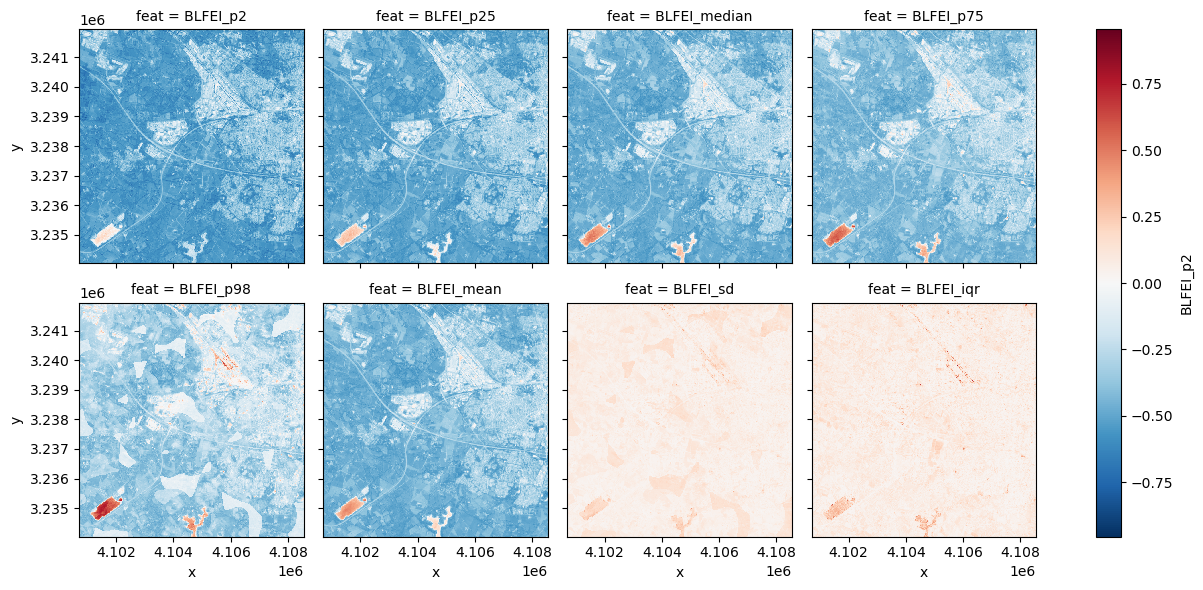

In [171]:
# visualize just the BLFEI features as faceted plot
arrlist = []
lMedian = [x for x in data.keys() if ('BLFEI' in x) and ('_sum' not in x)]
for varname in lMedian:
    tmp      = data[varname]
    arrlist.append(tmp)
xrda4D = xarray.concat(arrlist, pd.Index(lMedian, name='feat'))
xrda4D.plot(col="feat", col_wrap=4, )

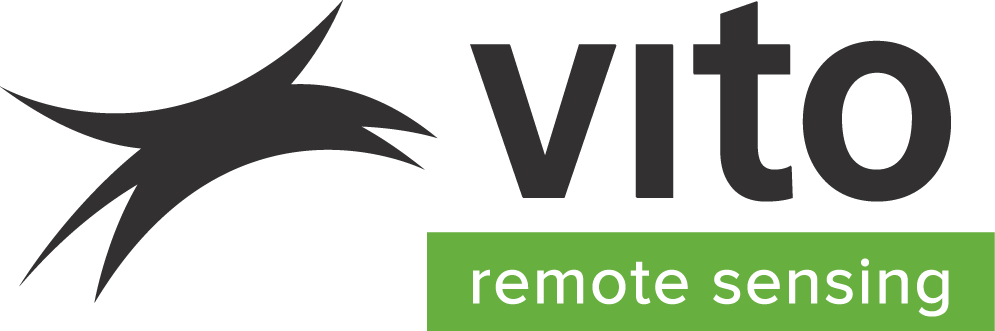